In [2]:
# Instructions for submission

# 1. Rename this file to groupXX_PPGHR.ipynb where XX is your group number as visible in the Google spreadsheet
# 2. State the team members (e-mail, legi):
# example@student.ethz.ch, XX-YYY-ZZZ
# TO BE FILLED
# TO BE FILLED
# 3. Kaggle team name: TO BE FILLED
# 4. Upload this file in a zipped folder together with your final predictions to the provided Polybox link. See the Submission section in the PDF for more details.

In [3]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import os
current_directory = os.getcwd()
relative_path = "kaggle/input/24-exercise1/mhealth24_data_public.npy"
full_path = os.path.join(current_directory, relative_path)

In [5]:
sampling_rate = 128  # Hz

# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load(full_path, allow_pickle=True).item() # now it is a dict

print('Keys for data:', data.keys())

# Example to extract the data from phase 0
phase0_data = data['phase 0']
print('Keys for phase 0:', phase0_data.keys())

# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']

Keys for data: dict_keys(['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5'])
Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])


Functions

In [33]:
import numpy as np
# Function to plot any signal with time on the x-axis
def plot_signal(signal, title, ylabel, sampling_rate=128):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t, signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]')
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    plt.show()

def subplot_signal(signal,filtred_signal, title, ylabel, sampling_rate):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots(2)
    ax[0].plot(t, signal)
    ax[1].plot(t, filtred_signal)
    ax[0].set_title("Unfiltered PPG signal")
    ax[1].set_title("Filtered PPG signal")

    ax[0].set_xlabel('Time [min:sec]')
    ax[1].set_xlabel('Time [min:sec]')

    ax[0].set_ylabel(ylabel)
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    plt.show()

def filter_signal(signal, lowHR, highHR, sampling_rate):
    low=lowHR/60
    high=highHR/60
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Create a filter that is 1 for frequencies between low and high, and 0 elsewhere
    filter = (np.abs(frequencies) >= low) & (np.abs(frequencies) <= high)
    # Apply the filter to the FFT
    filtered_fft = fft * filter
    # Compute the inverse FFT
    filtered_signal = np.fft.ifft(filtered_fft)
    return filtered_signal

def plot_frequency_spectrum(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Plot the frequencies
    plt.plot(frequencies, np.abs(fft))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title('Frequency Spectrum')
    plt.show()
def calculate_avarage_freq2(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Apply the filter to the FFT
    print(frequencies)
    return 




# If you want to be able to interactively look at your plotted data (e.g., zooming in or out),
# uncomment the line with "%matplotlib widget" below
# Careful: This does not work on Kaggle, but requires that you run the Jupyter Notebook locally on your computer
# If you have an interactive plot and you want to go back to the non-interactive plot, comment the line with 
# "%matplotlib widget" out and restart your kernel
# If you accidently run this script on Kaggle when "%matplotlib widget" is not commented out and you receive an error afterwards that your plot cannot be plotted, comment "%matplotlib widget" out and restart the kernel via "Run << Factory reset"




def calculate_average_frequency(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Calculate the average frequency
    print(fft)
    print(frequencies)
    
    average_frequency = np.sum(np.abs(frequencies*fft )) 
    return average_frequency

def get_bpm_with_highest_amplitude(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Find the index of the maximum amplitude in the FFT result
    max_amplitude_index = np.argmax(np.abs(fft))
    # Get the frequency with the highest amplitude
    frequency_with_highest_amplitude = frequencies[max_amplitude_index]
    return frequency_with_highest_amplitude*60

 

#TODO 
# 1. devide the PPG signal in 30 seconds windows
# 2. compute the FFT for each window
# Plot the fft 
# 3. Bandpass the signals between [40, 180] bpm 
# plot the filtered fft 
# plot the data in time domain
# 4. Compute the avarage HR for each window by taking the strengt oft the freqiencies in the feqincy domain and add them togheter deppending on ther amplitude ad normolize to a bpm value 




Filter the signal

In [19]:
# %matplotlib widget

# Example plot of a 10-second window of the PPG signal
plot_window_start = 0  # in seconds
plot_window_end = 30  # in seconds
unfiltred_signal=ppg_phase0[plot_window_start*sampling_rate:plot_window_end*sampling_rate]
filtred_signal= filter_signal(ppg_phase0[plot_window_start*sampling_rate:plot_window_end*sampling_rate],40,180,128)


Plot the signal

/Users/anton_heden/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


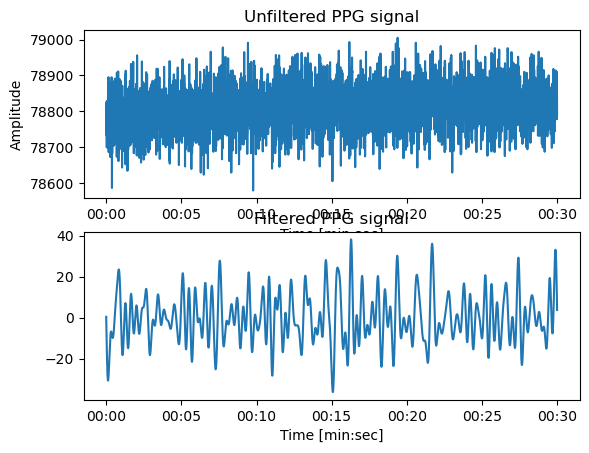

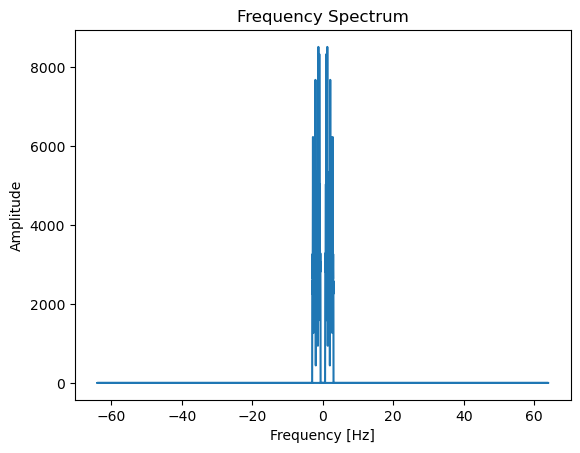

In [20]:
subplot_signal(unfiltred_signal,filtred_signal, 'PPG wrist', 'Amplitude', 128)
plot_frequency_spectrum(filtred_signal, 128)


Calculate the avarage bpm value

In [35]:

print(get_bpm_with_highest_amplitude(filtred_signal, 128))


76.0


heart rate ploted over a day

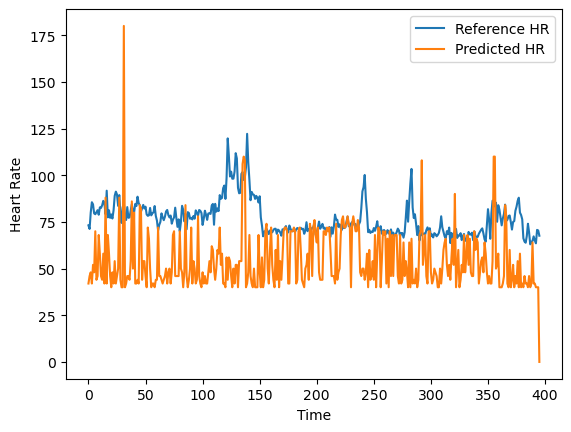

In [59]:
def get_bpm_over_time(signal,sampling_rate=128,sampling_time_signal=30):

    bpms=np.zeros(int(np.floor(len(signal)/(sampling_time_signal*sampling_rate))))
    j=0
    for i in range(0, len(signal)-sampling_time_signal*sampling_rate, sampling_time_signal*sampling_rate):
        this_signal = signal[i:i+sampling_time_signal*sampling_rate]
        bpms[j] = abs(get_bpm_with_highest_amplitude(this_signal,sampling_rate))
        j+=1
    return bpms

filtred_signal= filter_signal(ppg_phase0,40,180,128)
predicted_bpms=get_bpm_over_time(filtred_signal,sampling_time_signal=30)




xTimes = np.arange(0, len(predicted_bpms))

plt.plot(xTimes, ref_hr_phase0, label='Reference HR')
plt.plot(xTimes, predicted_bpms, label='Predicted HR')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()



#xTimes=np.arange(0, len(predicted_bpms))
#plt.plot(xTimes,predicted_bpms)
#plt.show()

In [7]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr_phase0, ref_hr_phase0)

Mean error: 42.491, Median error 35.605
Resulting score 39.048


In [8]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = list(np.random.randint(40, 180, 396))
pred_hr_phase1 = list(np.random.randint(40, 180, 396))
pred_hr_phase2 = list(np.random.randint(40, 180, 396))
pred_hr_phase3 = list(np.random.randint(40, 180, 396))
pred_hr_phase4 = list(np.random.randint(40, 180, 57))
pred_hr_phase5 = list(np.random.randint(40, 180, 57))

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')

# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv('/kaggle/working/submission.csv', index=False)

OSError: Cannot save file into a non-existent directory: '/kaggle/working'